In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [2]:
pd_vs_general_comorbidities = pd.read_csv('data/advanced_comorbidities.csv')
pd_vs_general_procedures = pd.read_csv('data/advanced_procedures.csv')
# age_stratified_comorbidities = pd.read_csv('diaz_rincon/motor_fluctuations_pd/data/age-stratified_comorbidities.csv')
age_adjusted_comorbidities = pd.read_csv('data/age-adjusted_comorbidities.csv')

In [3]:
print("Datasets loaded successfully!")
print(f"Comorbidities: {len(pd_vs_general_comorbidities)} conditions")
print(f"Procedures: {len(pd_vs_general_procedures)} procedures")
print(f"Age-Adjusted: {len(age_adjusted_comorbidities)} conditions")

Datasets loaded successfully!
Comorbidities: 9921 conditions
Procedures: 4368 procedures
Age-Adjusted: 9921 conditions


# 1. PD vs General Population Comparison

In [4]:
# This visualization shows which conditions/procedures differ most between PD patients 
# and the general population. Negative values mean conditions are MORE common in PD.
# 
# Data source: advanced_comorbidities.csv or advanced_procedures.csv with columns:
# - concept_name: Condition name
# - percentage_of_patients: % of PD patients with condition
# - percentage_in_general_population: % of general population with condition
# - rate_difference: general_rate - PD_rate (negative = more common in PD)

def plot_pd_vs_general(df, column_type='comorbidities', n=15, concept_col='concept_name'):
    """
    Create a horizontal bar chart showing the difference in rates between 
    PD patients and general population.
    """
    # Create a categorical variable for color-coding
    df = df.copy()
    df['category'] = pd.cut(
        df['rate_difference'],
        bins=[-100, -20, -10, -5, 5, 100],
        labels=['Much more common in PD (>20% higher)', 
                'More common in PD (10-20% higher)', 
                'Somewhat more common in PD (5-10% higher)', 
                'Similar rates (±5%)', 
                'Less common in PD (>5% lower)']
    )
    
    # Sort and select top differences
    df = df.sort_values('rate_difference').head(n)
    
    # Create custom colormap for categories
    colors = ['#d73027', '#fc8d59', '#fee090', '#e0f3f8', '#91bfdb']
    category_colors = {}
    for i, category in enumerate(df['category'].cat.categories):
        if i < len(colors):
            category_colors[category] = colors[i]
    
    # Create the plot
    plt.figure(figsize=(14, 10))
    bars = plt.barh(
        y=range(len(df)), 
        width=df['rate_difference'], 
        color=[category_colors.get(cat, 'gray') for cat in df['category']]
    )
    
    # Add labels and formatting
    plt.yticks(range(len(df)), df[concept_col])
    plt.xlabel('Rate Difference (General Population % - PD %)', fontsize=12)
    plt.axvline(x=0, color='gray', linestyle='--')
    plt.title(f'Top {n} Differential {column_type.title()} in PD vs General Population\n' + 
              'Negative values = MORE common in PD patients', 
              fontsize=16, fontweight='bold')
    
    # Add value labels to bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        label_position = width + (0.5 if width >= 0 else -0.5)
        plt.text(label_position, bar.get_y() + bar.get_height()/2, 
                 f'{width:.1f}%', va='center')
    
    # Add a legend
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color=color, lw=4, label=label) 
                      for label, color in category_colors.items()]
    plt.legend(handles=legend_elements, title='Prevalence Category', 
               loc='lower right', bbox_to_anchor=(1, -0.15), ncol=2)
    
    plt.tight_layout()
    plt.show()


1. PD vs General Population Comorbidities


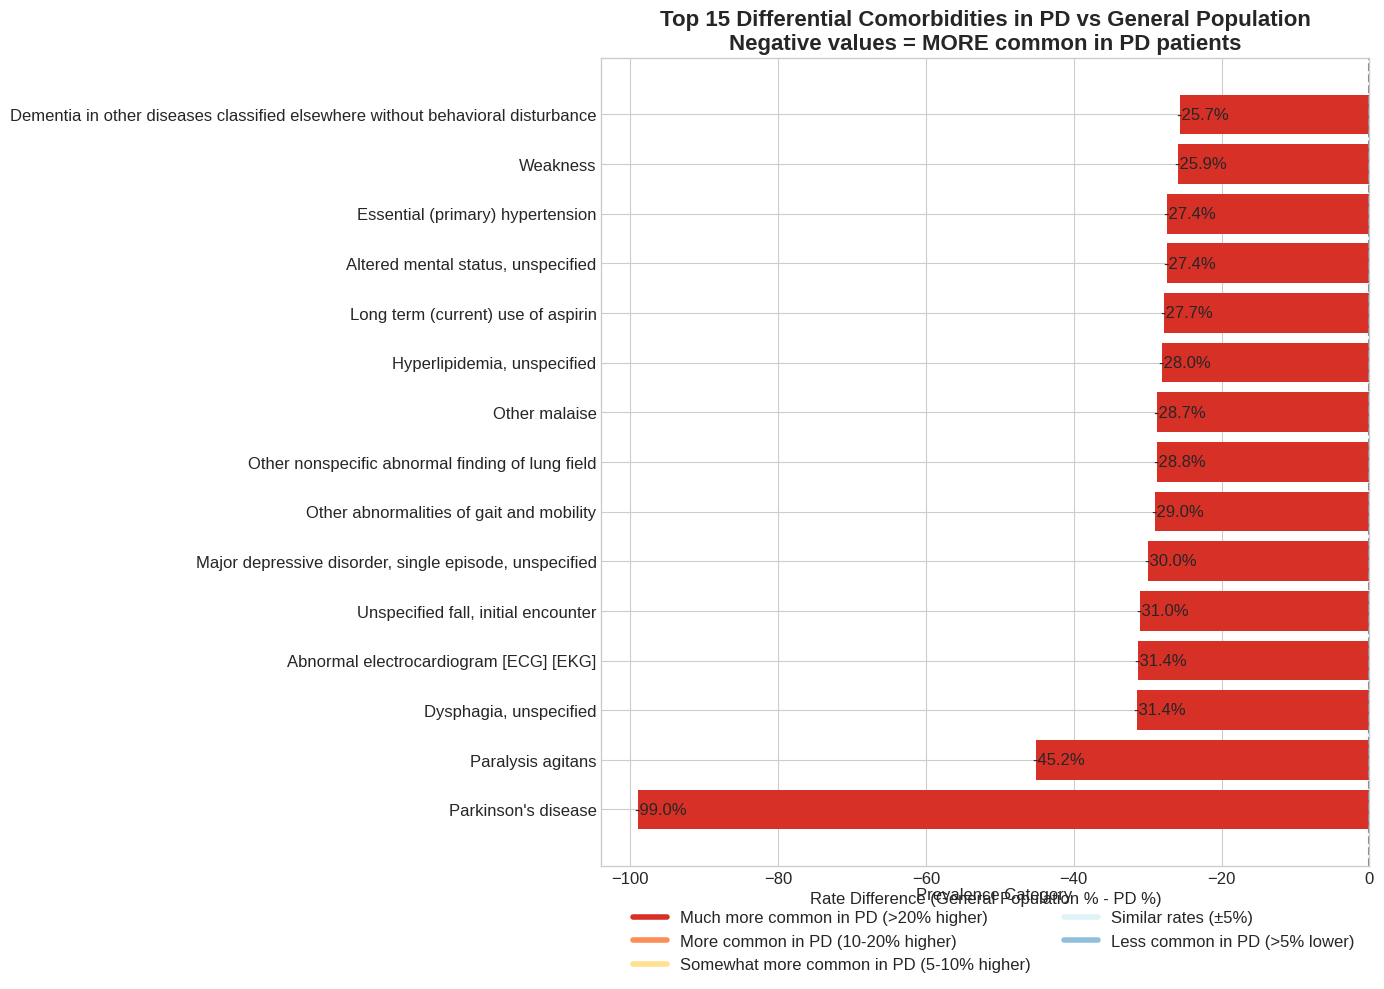

In [5]:
print("\n1. PD vs General Population Comorbidities")
plot_pd_vs_general(pd_vs_general_comorbidities, 'comorbidities', n=15)


3. PD vs General Population Procedures


/tmp/ipykernel_62184/913505491.py:67: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


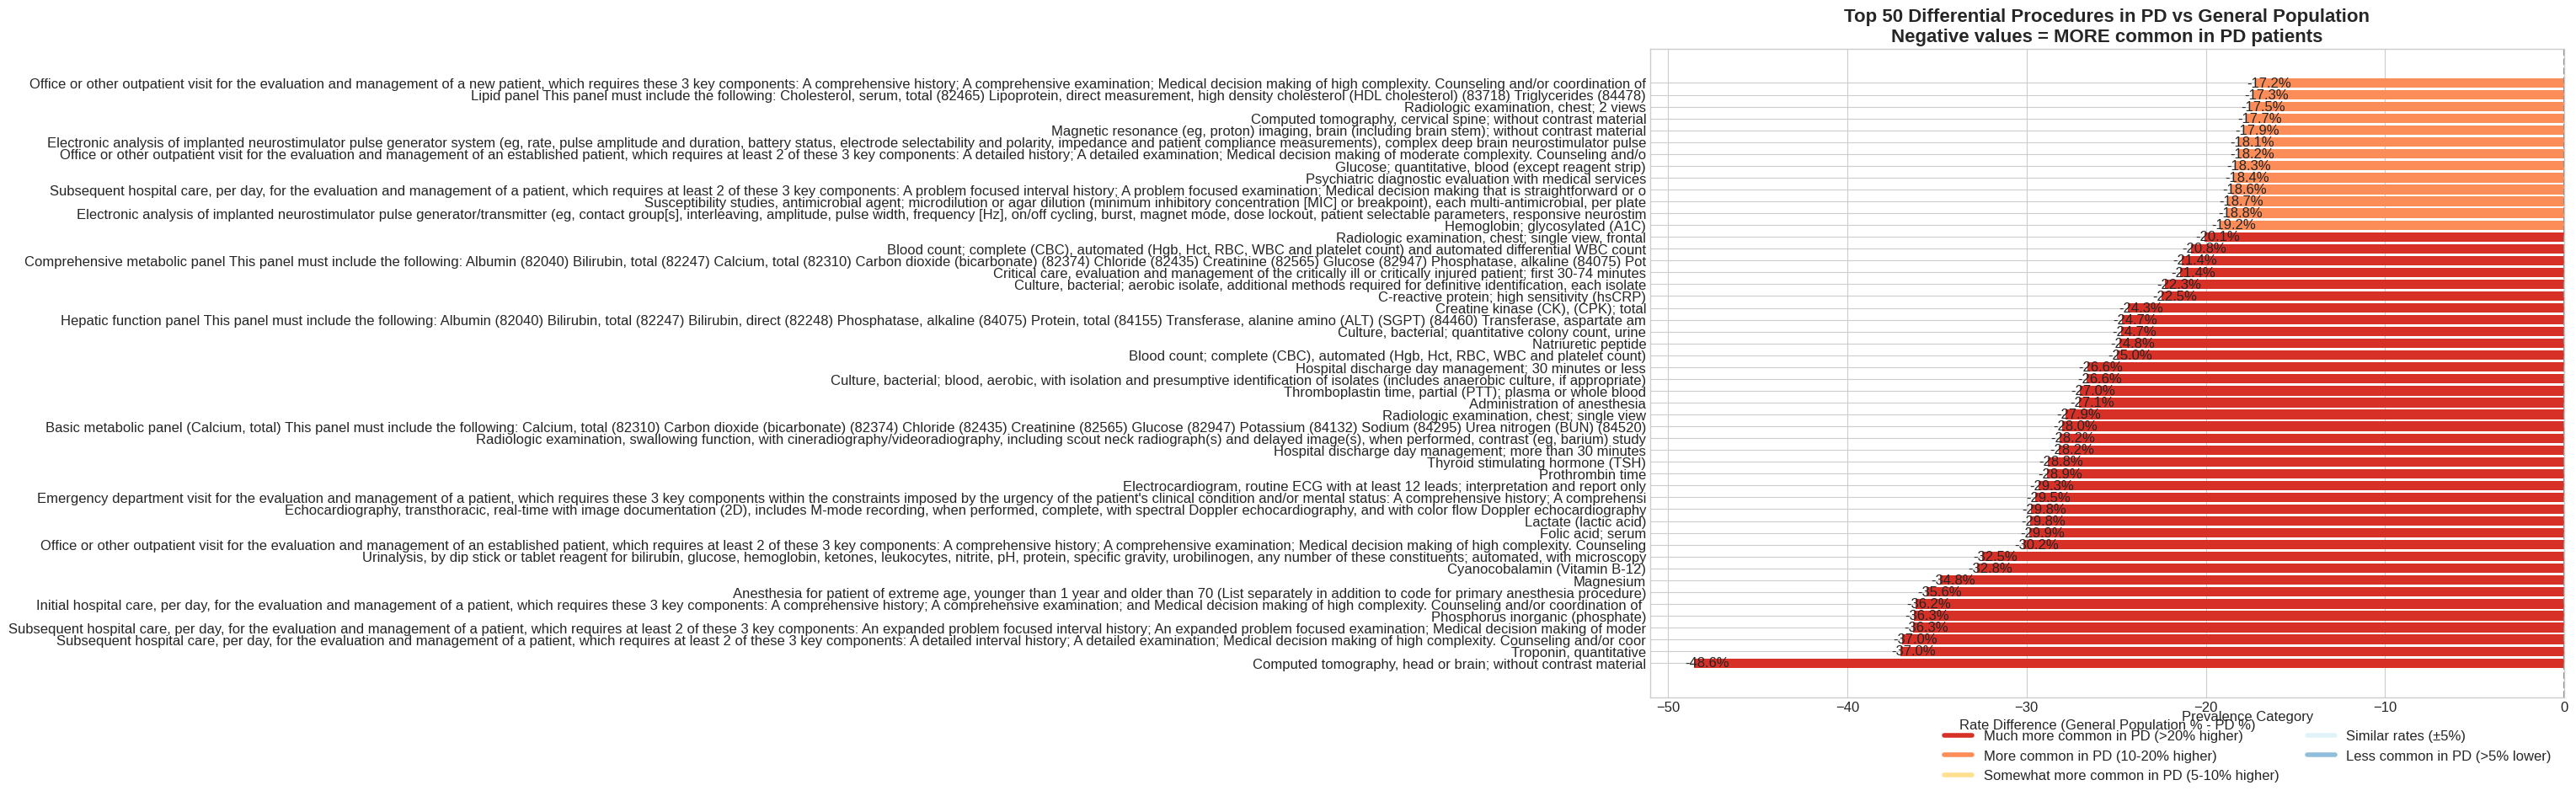

In [ ]:
print("\n3. PD vs General Population Procedures")
plot_pd_vs_general(pd_vs_general_procedures, 'procedures', n=50)
# Todo: Split lab tests from real procedures. Do advanced query. CPT, Procedure codes, etc. PD vs General population. Look into actual values
# Look into CT for PD patients. Subencounters

# 2. Relative Risk Analysis

In [18]:
# This scatter plot shows the relationship between prevalence and relative risk.
# - X-axis: How common the condition is in PD patients (%)
# - Y-axis: How many times more/less common in PD vs general population (log scale)
# - Values above 1.0 = MORE common in PD patients
# - Color indicates magnitude of difference
# 
# Data source: advanced_comorbidities.csv with columns:
# - concept_name: Condition name
# - percentage_of_patients: % of PD patients with condition
# - relative_risk: PD_rate / general_rate
# - rate_difference: For color coding

def plot_relative_risk(df, column_type='comorbidities', 
                      concept_col='concept_name',
                      prevalence_col='percentage_of_patients',
                      risk_col='relative_risk', 
                      diff_col='rate_difference'):
    """
    Create a scatter plot of relative risk vs prevalence with annotations.
    """
    # Filter for reasonable prevalence and valid risk values
    df_filtered = df[
        (df[prevalence_col] >= 2) & 
        (df[risk_col].notna()) & 
        (df[risk_col] > 0)
    ].copy()
    
    # Create categories for color-coding
    df_filtered['category'] = pd.cut(
        df_filtered[diff_col],
        bins=[-100, -20, -10, -5, 5, 100],
        labels=['Much more common in PD (>20% higher)', 
                'More common in PD (10-20% higher)', 
                'Somewhat more common in PD (5-10% higher)', 
                'Similar rates (±5%)', 
                'Less common in PD (>5% lower)']
    )
    
    # Create custom colormap for categories
    colors = ['#d73027', '#fc8d59', '#fee090', '#e0f3f8', '#91bfdb']
    category_colors = {}
    for i, category in enumerate(df_filtered['category'].cat.categories):
        if i < len(colors):
            category_colors[category] = colors[i]
    
    # Plot setup
    plt.figure(figsize=(14, 10))
    
    # Create scatter plot
    for category in df_filtered['category'].cat.categories:
        group = df_filtered[df_filtered['category'] == category]
        if len(group) > 0:  # Only plot if there are points in this category
            plt.scatter(
                x=group[prevalence_col],
                y=group[risk_col],
                color=category_colors.get(category, 'gray'),
                alpha=0.7,
                label=category,
                s=100  # Increase point size
            )
    
    # Add reference line at relative risk = 1
    plt.axhline(y=1, color='gray', linestyle='--')
    
    # Log scale for Y-axis and set limits
    plt.yscale('log')
    ymin = max(0.1, df_filtered[risk_col].min() * 0.8)
    ymax = df_filtered[risk_col].max() * 1.2
    plt.ylim(ymin, ymax)
    
    # Label high prevalence or high relative risk items
    # for idx, row in df_filtered[
    #     (df_filtered[prevalence_col] >= 20) | 
    #     (df_filtered[risk_col] >= 3)
    # ].iterrows():
    #     plt.annotate(
    #         row[concept_col],
    #         (row[prevalence_col], row[risk_col]),
    #         xytext=(5, 0),
    #         textcoords='offset points',
    #         fontsize=10,
    #         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    #     )
    
    # Add labels and title
    plt.xlabel('Prevalence in PD Patients (%)')
    plt.ylabel('Relative Risk (log scale)')
    plt.title(f'Relative Risk vs Prevalence of {column_type.title()} in PD Patients\n' +
              'Values above 1.0 = MORE common in PD patients', 
              fontsize=16, fontweight='bold')
    
    # Add legend if we have categories
    if len(df_filtered['category'].dropna().unique()) > 0:
        plt.legend(title='Prevalence Category', loc='upper right')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


2. Relative Risk Analysis for Comorbidities


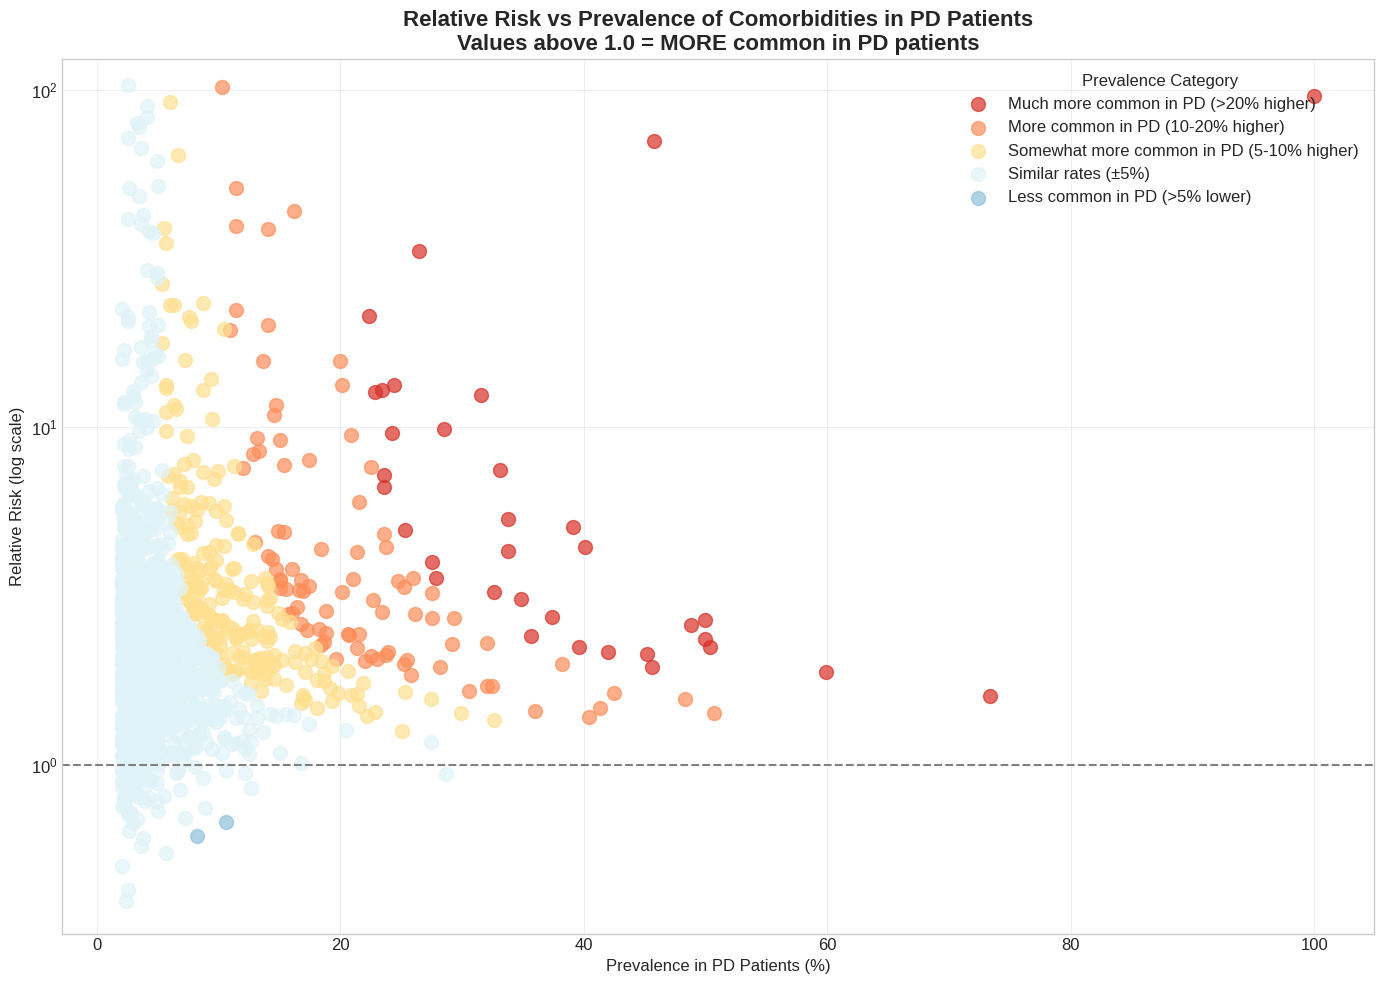

In [ ]:
print("\n2. Relative Risk Analysis for Comorbidities")
plot_relative_risk(pd_vs_general_comorbidities, 'comorbidities')
# Look into D3

# 3. Age-Adjusted Comparison

In [9]:
# This visualization shows how age adjustment affects the relationship between
# conditions and PD. It accounts for the fact that PD patients are typically older.
# 
# First plot: Shows top conditions based on age-adjusted differences
# Second plot: Compares raw vs. age-adjusted differences for the same conditions
# 
# Data source: age-adjusted_comorbidities.csv with columns:
# - concept_name: Condition name
# - percentage_of_patients: % of PD patients with condition
# - rate_difference: Raw difference (general - PD)
# - adjusted_rate_difference: Age-adjusted difference

def plot_age_adjusted_comparison(df, n=15,
                               concept_col='concept_name',
                               raw_diff_col='rate_difference',
                               adj_diff_col='adjusted_rate_difference'):
    """
    Compare raw vs age-adjusted differences in comorbidity rates.
    """
    # Sort by absolute adjusted difference and get top n differences
    df_sorted = df.sort_values(adj_diff_col).copy()
    if len(df_sorted) > n:
        top_adjusted = pd.concat([df_sorted.head(n//2), df_sorted.tail(n//2)])
    else:
        top_adjusted = df_sorted
    
    # 1. First plot: Age-Adjusted Differences Only
    plt.figure(figsize=(14, 10))
    
    # Normalize for colormap
    norm_values = (top_adjusted[adj_diff_col] - top_adjusted[adj_diff_col].min()) / \
                 (top_adjusted[adj_diff_col].max() - top_adjusted[adj_diff_col].min()) \
                 if top_adjusted[adj_diff_col].max() > top_adjusted[adj_diff_col].min() else 0.5
    
    bars = plt.barh(
        y=range(len(top_adjusted)),
        width=top_adjusted[adj_diff_col],
        color=plt.cm.coolwarm(norm_values),
        alpha=0.8,
        label='Age-Adjusted Difference'
    )
    
    # Add labels
    plt.yticks(range(len(top_adjusted)), top_adjusted[concept_col])
    plt.xlabel('Rate Difference (General Population % - PD %)', fontsize=12)
    plt.axvline(x=0, color='gray', linestyle='--')
    plt.title('Top Differential Comorbidities: Age-Adjusted Comparison\n' +
              'Negative values = MORE common in PD patients', 
              fontsize=16, fontweight='bold')
    
    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        label_position = width + (0.5 if width >= 0 else -0.5)
        plt.text(label_position, bar.get_y() + bar.get_height()/2, 
                 f'{width:.1f}%', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # 2. Second plot: Raw vs Adjusted Differences
    plt.figure(figsize=(14, 10))
    
    # Sort by the difference between raw and adjusted
    impact_of_adjustment = (top_adjusted[raw_diff_col] - 
                          top_adjusted[adj_diff_col]).abs()
    top_adjusted = top_adjusted.loc[impact_of_adjustment.sort_values(ascending=False).index]
    
    # Prepare data for grouped bar chart
    x = np.arange(len(top_adjusted))
    width = 0.35
    
    # Create grouped bars
    plt.barh(x + width/2, top_adjusted[raw_diff_col], width, 
            label='Raw Difference', color='skyblue')
    plt.barh(x - width/2, top_adjusted[adj_diff_col], width, 
            label='Age-Adjusted Difference', color='coral')
    
    # Add labels and formatting
    plt.yticks(x, top_adjusted[concept_col])
    plt.xlabel('Rate Difference (General Population % - PD %)', fontsize=12)
    plt.axvline(x=0, color='gray', linestyle='--')
    plt.title('Impact of Age Adjustment on Comorbidity Rate Differences\n' +
              'Negative values = MORE common in PD patients', 
              fontsize=16, fontweight='bold')
    plt.legend()
    
    plt.tight_layout()
    plt.show()



4. Age-Adjusted Comorbidity Comparison


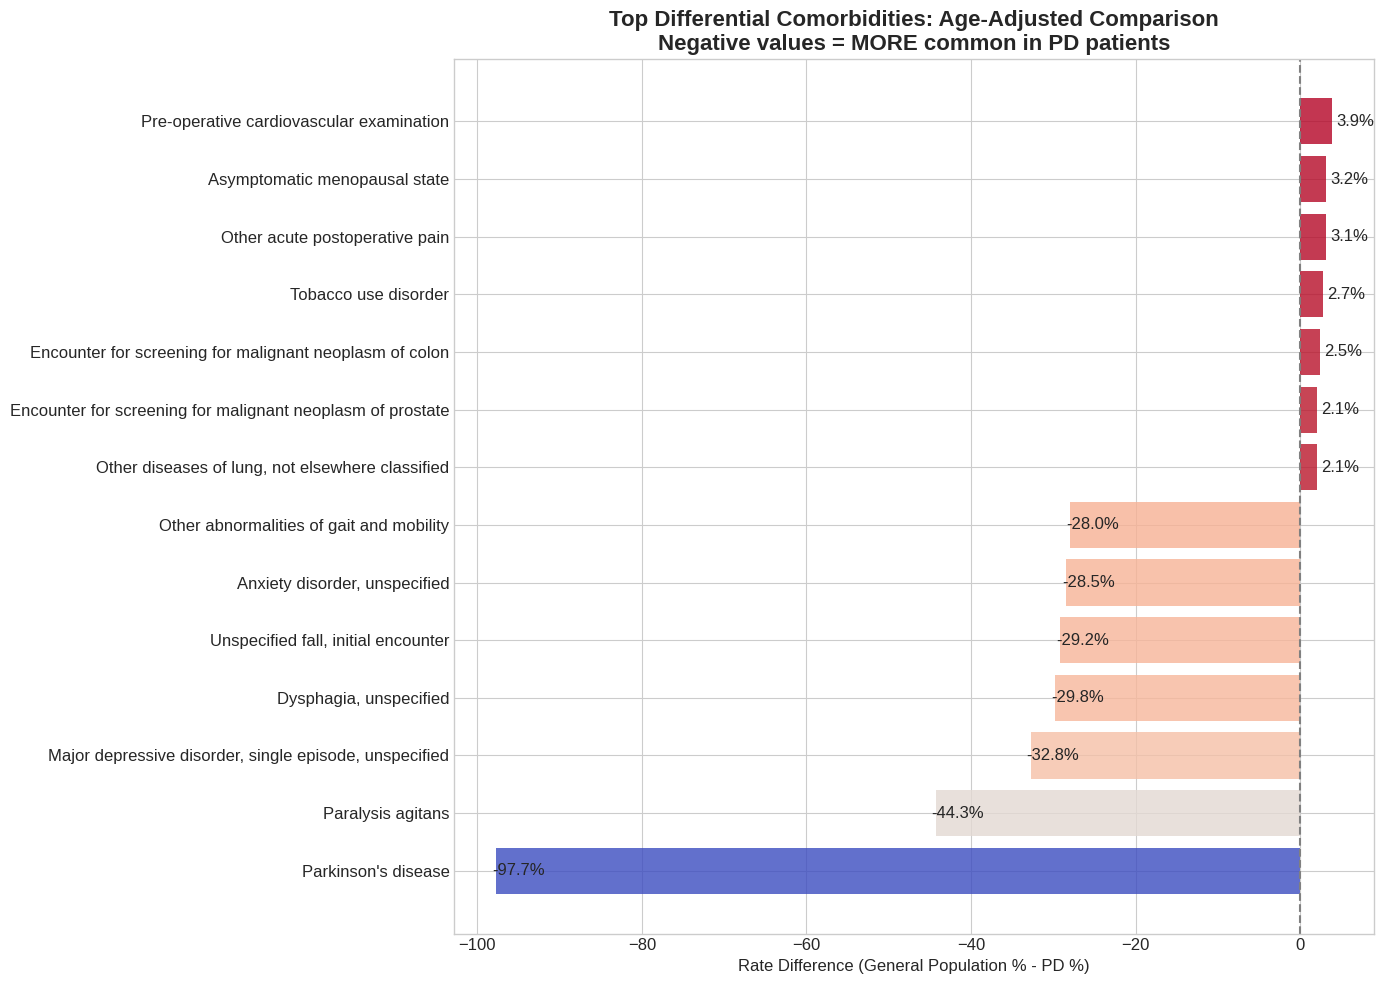

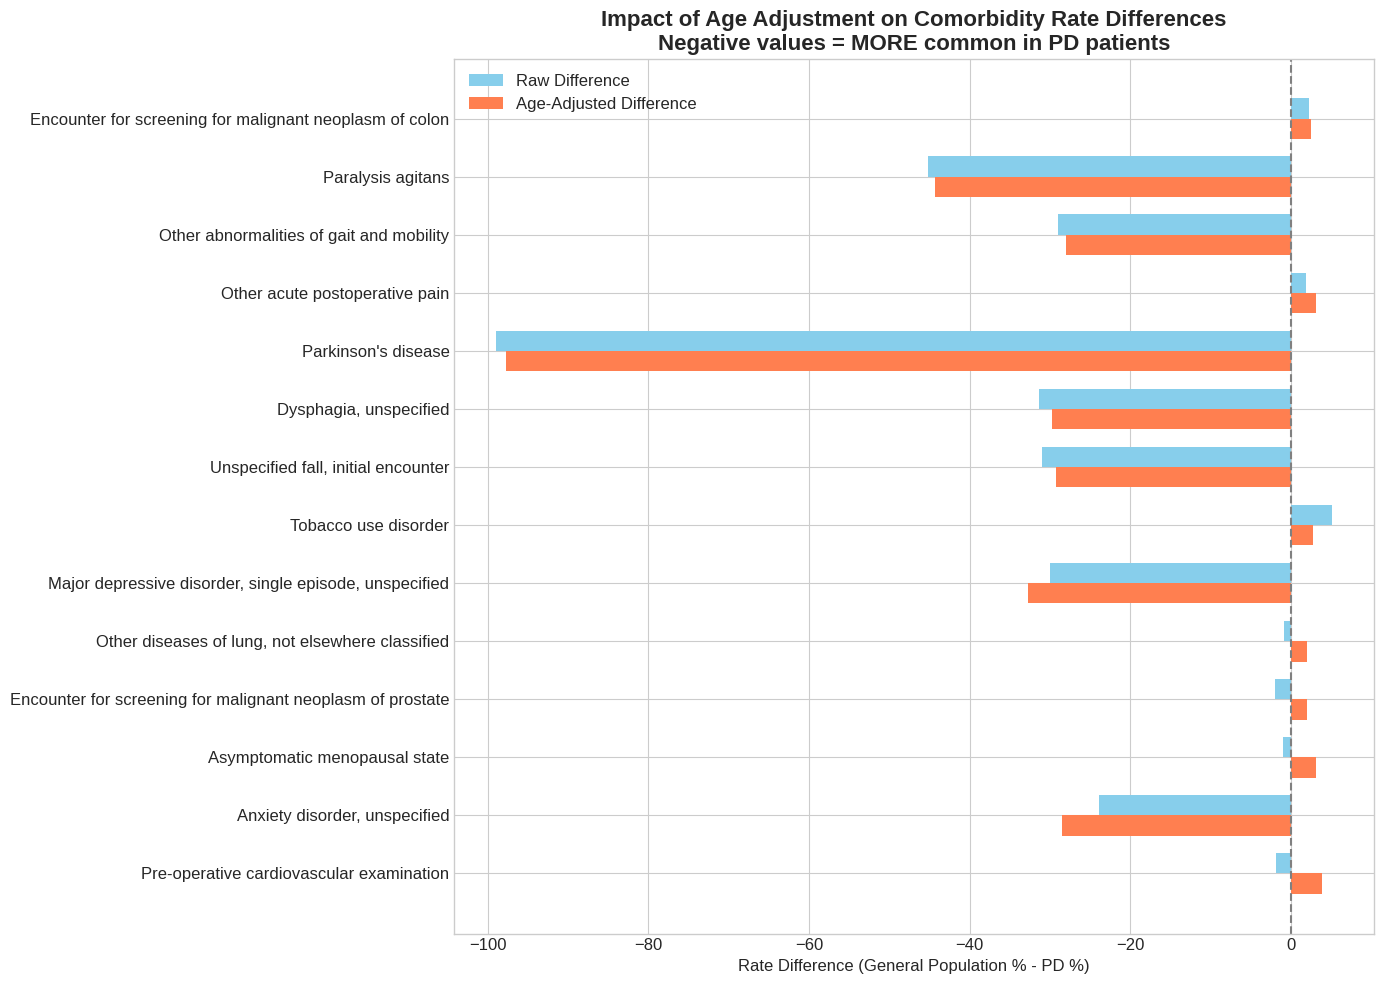

In [10]:

print("\n4. Age-Adjusted Comorbidity Comparison")
plot_age_adjusted_comparison(age_adjusted_comorbidities, n=15)

In [15]:
age_adjusted_comorbidities

,condition_source_value,concept_name,unique_condition_count,percentage_of_patients,percentage_in_general_population,rate_difference,relative_risk,adjusted_percentage_in_general_population,adjusted_rate_difference,adjusted_relative_risk
0,ICD10: G20,Parkinson's disease,631,100.000000,1.043063,-98.956937,95.871512,2.282916,-97.717084,43.803628
1,ICD9: 332.0,Paralysis agitans,289,45.800316,0.647511,-45.152805,70.732914,1.484201,-44.316115,30.858559
2,ICD10: F32.9,"Major depressive disorder, single episode, uns...",308,48.811410,18.845585,-29.965825,2.590071,16.049574,-32.761836,3.041290
3,ICD10: R13.10,"Dysphagia, unspecified",247,39.144215,7.733368,-31.410847,5.061729,9.361145,-29.783070,4.181563
4,ICD10: W19.XXXA,"Unspecified fall, initial encounter",253,40.095087,9.098846,-30.996241,4.406612,10.890897,-29.204190,3.681523
...,...,...,...,...,...,...,...,...,...,...
9916,ICD10: H93.13,"Tinnitus, bilateral",11,1.743264,1.535110,-0.208154,1.135596,1.743581,0.000317,0.999818
9917,ICD9: E944.4,Other diuretics causing adverse effects in the...,1,0.158478,0.110663,-0.047815,1.432082,0.158169,-0.000309,1.001953
9918,ICD10: I63.232,Cerebral infarction due to unspecified occlusi...,1,0.158478,0.090751,-0.067727,1.746294,0.158265,-0.000213,1.001346
9919,ICD9: 805.02,Closed fracture of second cervical vertebra,1,0.158478,0.121767,-0.036711,1.301483,0.158338,-0.000140,1.000884



5. Detailed Examination of Age Adjustment Impact
Top 10 conditions with largest impact from age adjustment:


,concept_name,percentage_of_patients,percentage_in_general_population,rate_difference,adjusted_percentage_in_general_population,adjusted_rate_difference,adjustment_impact,adjustment_effect
43,"Hyperlipidemia, unspecified",59.904912,31.878508,-28.026404,44.455306,-15.449606,12.576798,Less associated with PD
48,Essential (primary) hypertension,73.375594,46.010783,-27.364811,58.519855,-14.855739,12.509073,Less associated with PD
1496,Unspecified essential hypertension,41.362916,28.096066,-13.266850,40.519900,-0.843016,12.423834,Less associated with PD
106,Atherosclerotic heart disease of native corona...,35.657686,14.856751,-20.800935,25.873791,-9.783895,11.017040,Less associated with PD
33,Long term (current) use of aspirin,50.396196,22.660576,-27.735620,33.372446,-17.023750,10.711870,Less associated with PD
469,Other and unspecified hyperlipidemia,32.488114,18.974628,-13.513486,29.268663,-3.219451,10.294035,Less associated with PD
63,Unspecified atrial fibrillation,27.892234,7.814546,-20.077688,15.120509,-12.771725,7.305963,Less associated with PD
117,Personal history of nicotine dependence,42.472266,25.996156,-16.476110,33.230900,-9.241366,7.234744,Less associated with PD
46,"Unspecified osteoarthritis, unspecified site",39.619651,17.725557,-21.894094,24.518059,-15.101592,6.792502,Less associated with PD
9,Abnormal electrocardiogram [ECG] [EKG],49.920760,18.570652,-31.350108,25.155883,-24.764877,6.585231,Less associated with PD


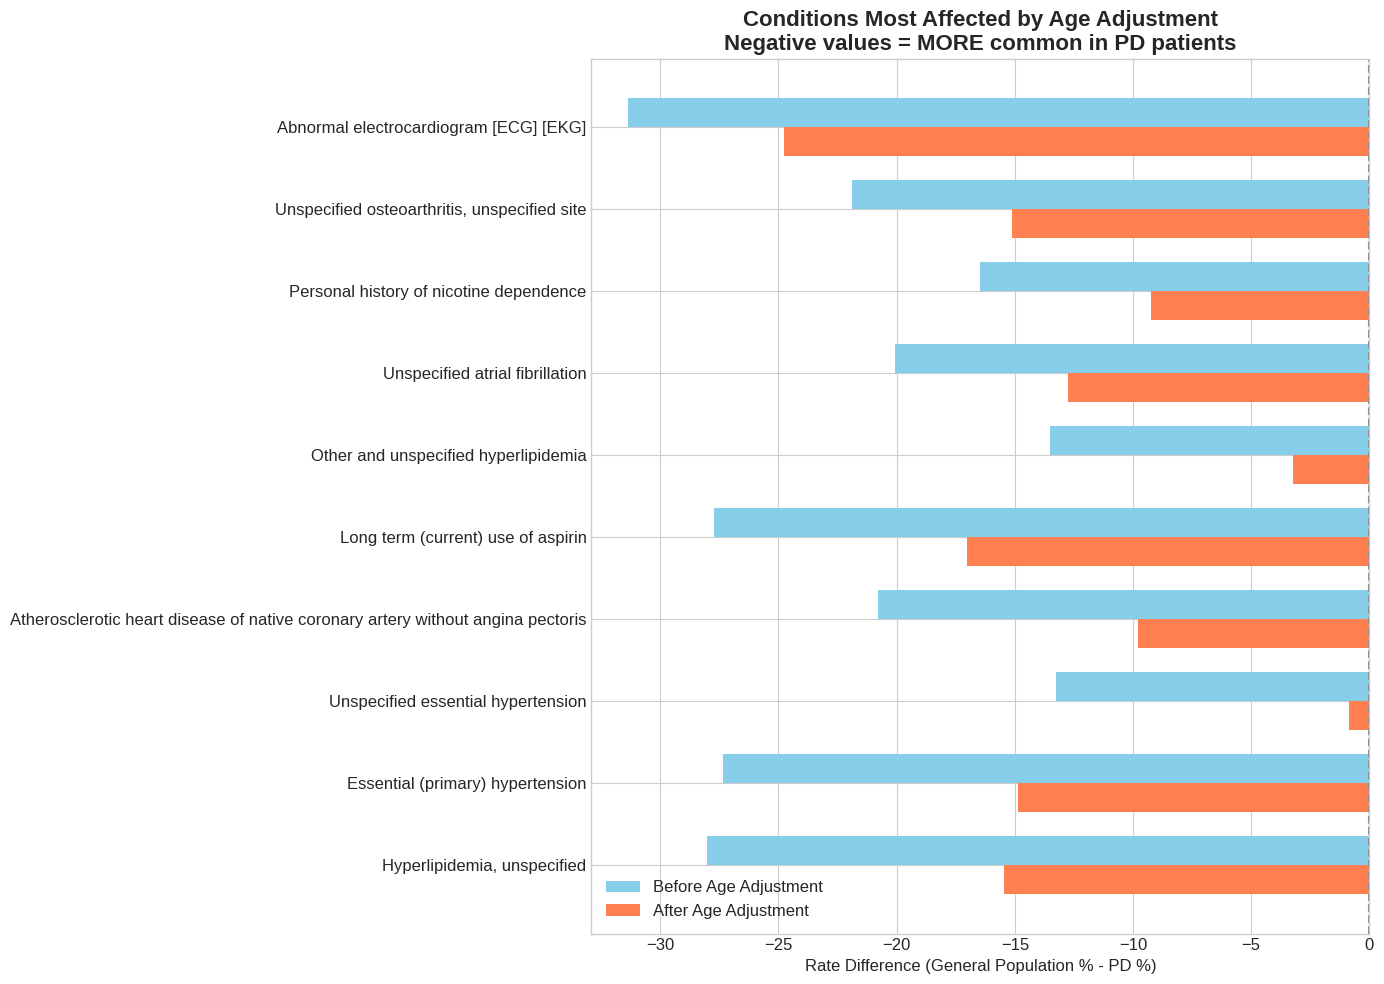

In [11]:
# This detailed analysis shows which conditions are most affected by age adjustment.
# 
# The table shows:
# - Raw vs. adjusted metrics for each condition
# - The absolute magnitude of the adjustment impact
# - Whether adjustment makes the condition more or less associated with PD
# 
# The plot visualizes how age adjustment changes our understanding of PD associations
# 
# Data source: age-adjusted_comorbidities.csv with columns as described above

#############################################
# 5. Additional Examination of Age-Adjusted Impact
#############################################

def examine_age_adjustment_impact(df, n=10):
    """
    Create a detailed analysis of how age adjustment changes the ranking and magnitude
    of condition differences.
    """
    # Calculate the absolute change in rate difference due to age adjustment
    df = df.copy()
    df['adjustment_impact'] = (df['adjusted_rate_difference'] - df['rate_difference']).abs()
    
    # Get conditions with the largest impact from age adjustment
    largest_impact = df.sort_values('adjustment_impact', ascending=False).head(n)
    
    # Create a comparison table
    print(f"Top {n} conditions with largest impact from age adjustment:")
    
    # Create a comparison DataFrame for display
    comparison = largest_impact[['concept_name', 'percentage_of_patients', 
                                'percentage_in_general_population', 'rate_difference',
                                'adjusted_percentage_in_general_population', 'adjusted_rate_difference',
                                'adjustment_impact']].copy()
    
    # Add direction of change column
    comparison['adjustment_effect'] = comparison.apply(
        lambda x: "More associated with PD" if x['adjusted_rate_difference'] < x['rate_difference']
                 else "Less associated with PD", axis=1
    )
    
    # Display the comparison
    display(comparison)
    
    # Create a visualization showing before/after adjustment
    plt.figure(figsize=(14, 10))
    
    # Sort by the magnitude of adjustment impact
    largest_impact = largest_impact.sort_values('adjustment_impact', ascending=False)
    
    # Prepare data for grouped bar chart
    x = np.arange(len(largest_impact))
    width = 0.35
    
    # Create grouped bars
    plt.barh(x + width/2, largest_impact['rate_difference'], width, 
            label='Before Age Adjustment', color='skyblue')
    plt.barh(x - width/2, largest_impact['adjusted_rate_difference'], width, 
            label='After Age Adjustment', color='coral')
    
    # Add labels and formatting
    plt.yticks(x, largest_impact['concept_name'])
    plt.xlabel('Rate Difference (General Population % - PD %)', fontsize=12)
    plt.axvline(x=0, color='gray', linestyle='--')
    plt.title('Conditions Most Affected by Age Adjustment\n' +
              'Negative values = MORE common in PD patients', 
              fontsize=16, fontweight='bold')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

print("\n5. Detailed Examination of Age Adjustment Impact")
examine_age_adjustment_impact(age_adjusted_comorbidities, n=10)

In [12]:
# These heatmaps show how condition prevalence varies across age groups within PD patients.
# Currently using synthetic data for demonstration.
# 
# First heatmap: Shows raw prevalence percentages in each age group
# Second heatmap: Shows difference from overall PD average
# 
# In a real implementation, this would use data from an age-stratified query with:
# - concept_name: Condition name
# - age_group: Age bracket (0-49, 50-59, etc.)
# - percentage_within_age_group: % prevalence in that age group
# - overall_percentage: % prevalence across all PD patients
# - difference_from_overall: Group % - Overall %

#############################################
# 4. Age-Stratified Heatmaps
#############################################

def create_sample_age_stratified(df, n=10):
    """
    Create a sample age-stratified dataset based on comorbidities data.
    Uses realistic age-prevalence patterns but is synthetic.
    """
    # Get top conditions by prevalence
    df = df.copy()
    if 'percentage_of_patients' in df.columns:
        df = df.sort_values('percentage_of_patients', ascending=False)
    elif 'unique_condition_count' in df.columns:
        df = df.sort_values('unique_condition_count', ascending=False)
    
    top_conditions = df.head(n)['concept_name'].tolist()
    
    # Define age groups
    age_groups = ['0-49', '50-59', '60-69', '70-79', '80+']
    
    # Create data
    data = []
    for condition in top_conditions:
        # Get base percentage for this condition
        base_pct = df.loc[df['concept_name'] == condition, 'percentage_of_patients'].values[0]
        
        for age_group in age_groups:
            # Generate age-specific variations with realistic patterns
            if age_group == '0-49':
                pct = max(5, base_pct * 0.4)  # Usually lower in younger patients
            elif age_group == '50-59':
                pct = max(10, base_pct * 0.7)
            elif age_group == '60-69':
                pct = base_pct * 0.9
            elif age_group == '70-79':
                pct = base_pct * 1.1
            else:  # 80+
                pct = min(100, base_pct * 1.3)  # Usually higher in older patients
                
            # Add some noise for variation
            pct = min(100, max(0, pct + np.random.normal(0, 5)))
            
            # Add to data
            data.append({
                'condition_source_value': df.loc[df['concept_name'] == condition, 'condition_source_value'].values[0] 
                    if 'condition_source_value' in df.columns else 'Unknown',
                'concept_name': condition,
                'age_group': age_group,
                'percentage_within_age_group': pct,
                'overall_percentage': base_pct,
                'difference_from_overall': pct - base_pct  # Positive = MORE common in age group
            })
    
    return pd.DataFrame(data)

def plot_age_stratified_heatmap(df, column_type='comorbidities', metric='difference_from_overall'):
    """
    Create a heatmap showing how conditions vary across age groups.
    For difference_from_overall: Positive values = MORE common in age group than overall PD
    """
    # Reshape the data for the heatmap
    pivot_df = df.pivot_table(
        index='concept_name',
        columns='age_group',
        values=metric,
        aggfunc='mean'  # In case there are duplicates
    )
    
    # Try to reorder age groups
    try:
        age_order = ['0-49', '50-59', '60-69', '70-79', '80+']
        existing_cols = [col for col in age_order if col in pivot_df.columns]
        if existing_cols:
            pivot_df = pivot_df.reindex(columns=existing_cols)
    except Exception as e:
        print(f"Warning: Could not reorder age groups: {e}")
    
    # Sort rows by the absolute maximum difference
    try:
        pivot_df['max_abs'] = pivot_df.apply(lambda x: np.max(np.abs(x)), axis=1)
        pivot_df = pivot_df.sort_values('max_abs', ascending=False).drop('max_abs', axis=1)
    except Exception as e:
        print(f"Warning: Could not sort rows by max absolute value: {e}")
    
    # Setup figure
    plt.figure(figsize=(12, len(pivot_df) * 0.5 + 2))
    
    # Create diverging colormap for differences, sequential for percentages
    if metric == 'difference_from_overall':
        cmap = sns.diverging_palette(220, 10, as_cmap=True)
        center = 0
        cbar_label = 'Percentage Difference (positive = MORE common in age group)'
        title_text = f"Age-Stratified {column_type.title()}: Difference from Overall PD Cohort (%)\nPositive values = MORE common in age group"
    else:
        cmap = 'YlOrRd'
        center = None
        cbar_label = 'Percentage within Age Group'
        title_text = f"Age-Stratified {column_type.title()}: Prevalence within Each Age Group (%)"
    
    # Create heatmap
    ax = sns.heatmap(
        pivot_df,
        annot=True,
        fmt='.1f',
        cmap=cmap,
        center=center,
        linewidths=0.5,
        cbar_kws={'label': cbar_label}
    )
    
    # Add title and labels
    plt.title(title_text, fontsize=16, fontweight='bold')
    plt.xlabel('Age Group')
    plt.ylabel('')
    
    plt.tight_layout()
    plt.show()
    
    return pivot_df

TODO: Look at comorbidities per age, check Ben's table, explain discrepancies in heatmap, use plotly for embeddings


5. Age-Stratified Analysis

Age-Stratified Comorbidities: Raw Percentages by Age Group


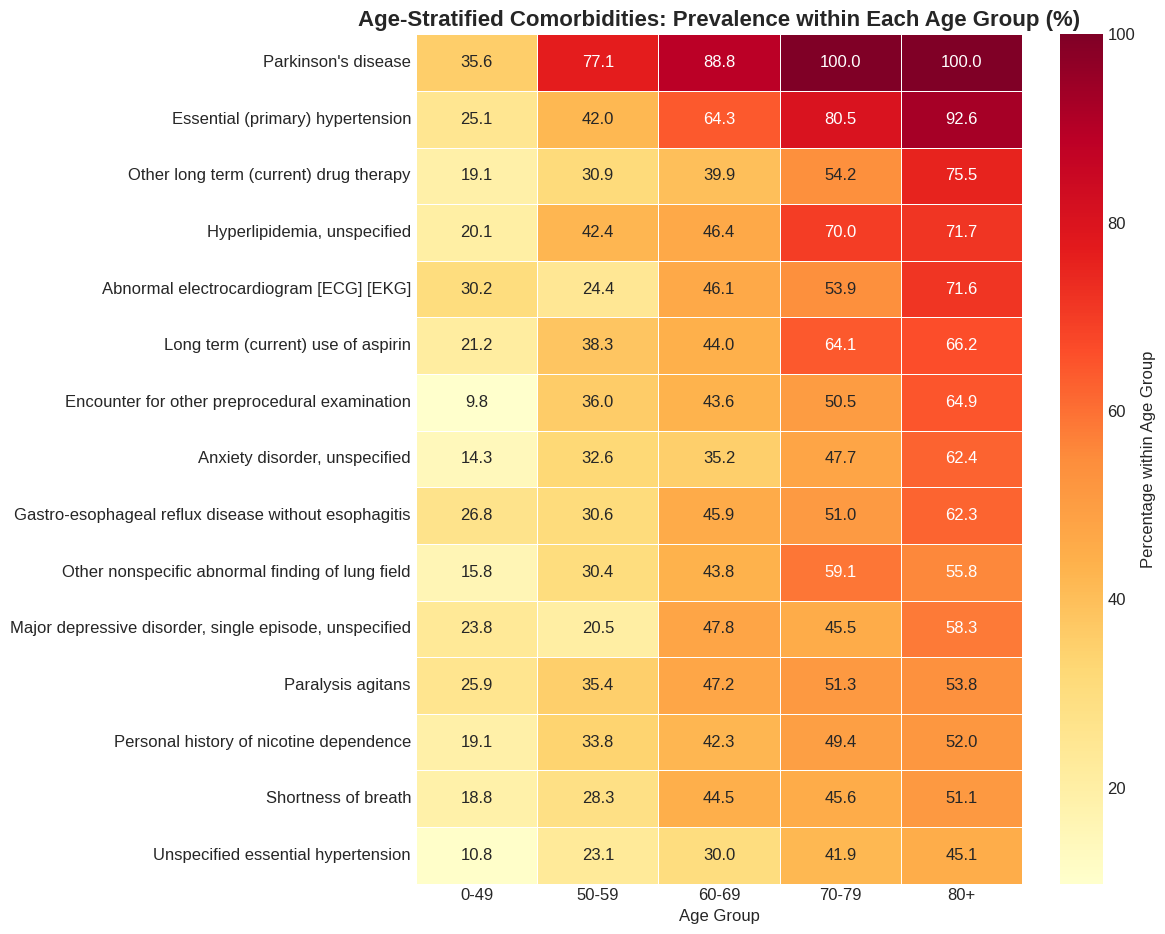


Age-Stratified Comorbidities: Difference from Overall PD Cohort


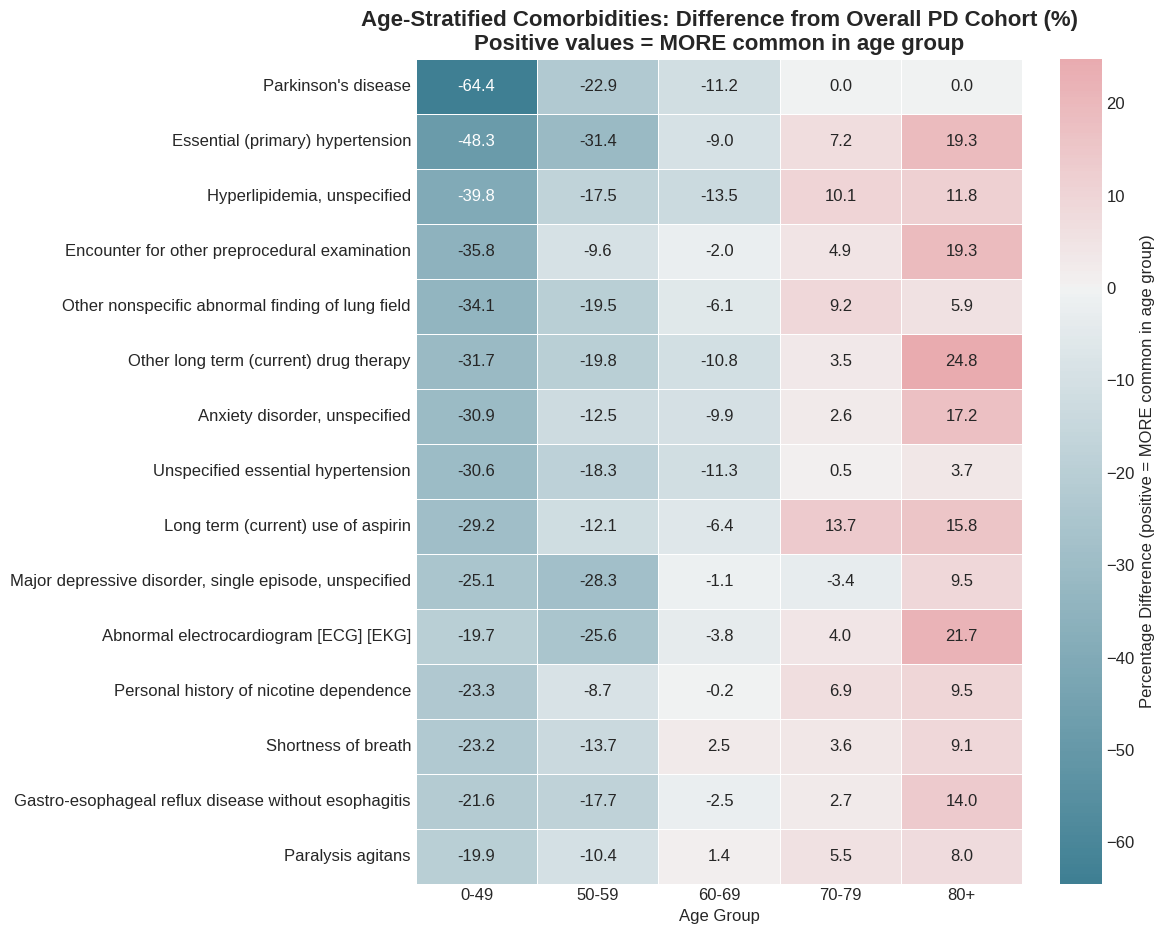


Detailed age patterns for specific conditions:


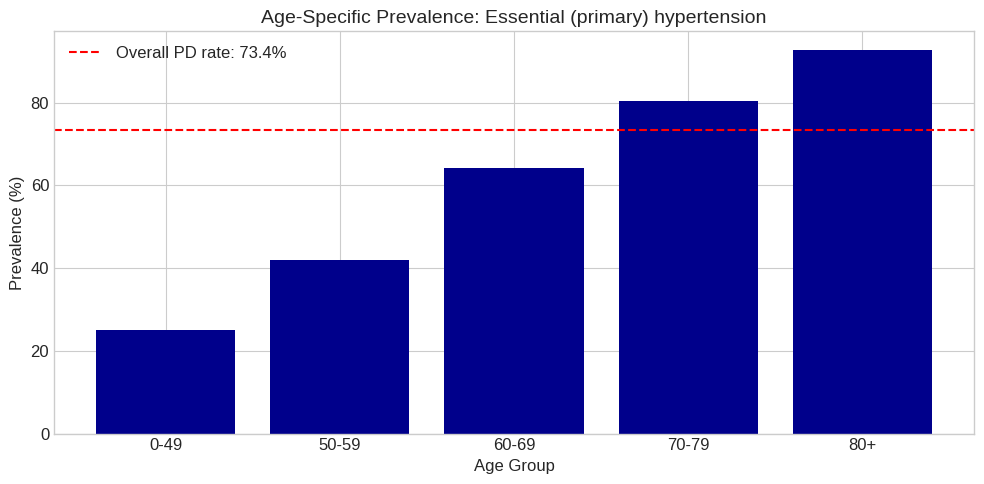

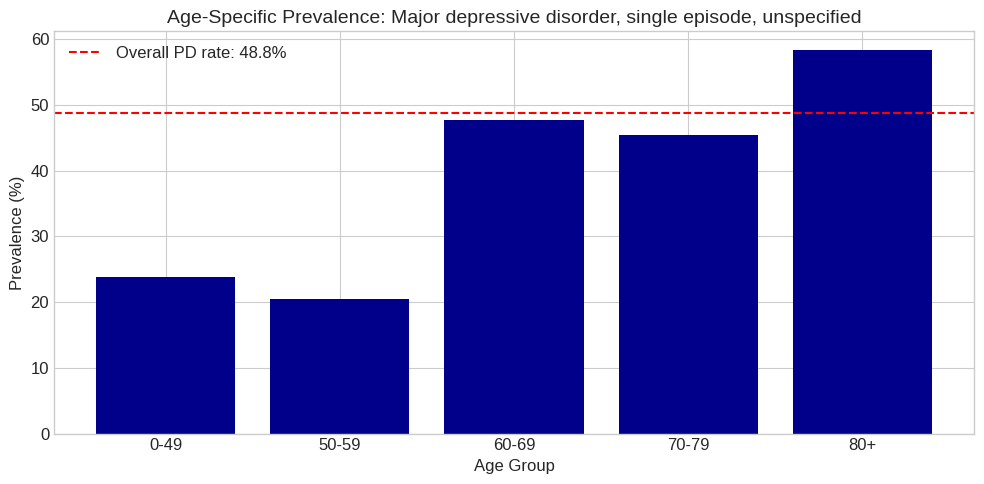

In [14]:
# After the other visualizations, add:

print("\n5. Age-Stratified Analysis")

# Create sample age-stratified data from your actual comorbidities
sample_age_stratified = create_sample_age_stratified(pd_vs_general_comorbidities, n=15)

# Create raw percentages by age group visualization
print("\nAge-Stratified Comorbidities: Raw Percentages by Age Group")
plot_age_stratified_heatmap(sample_age_stratified, 'comorbidities', 'percentage_within_age_group')

# Create difference from overall visualization
print("\nAge-Stratified Comorbidities: Difference from Overall PD Cohort")
plot_age_stratified_heatmap(sample_age_stratified, 'comorbidities', 'difference_from_overall')

# If you want to examine specific conditions by age groups:
print("\nDetailed age patterns for specific conditions:")
for condition in ['Essential (primary) hypertension', 'Major depressive disorder, single episode, unspecified', 'Dysphagia, unspecified'][:3]:  # limit to 3 conditions
    if condition in sample_age_stratified['concept_name'].values:
        condition_data = sample_age_stratified[sample_age_stratified['concept_name'] == condition]
        
        plt.figure(figsize=(10, 5))
        plt.bar(condition_data['age_group'], condition_data['percentage_within_age_group'], color='darkblue')
        plt.axhline(y=condition_data['overall_percentage'].iloc[0], color='red', linestyle='--', 
                   label=f'Overall PD rate: {condition_data["overall_percentage"].iloc[0]:.1f}%')
        plt.title(f'Age-Specific Prevalence: {condition}', fontsize=14)
        plt.xlabel('Age Group')
        plt.ylabel('Prevalence (%)')
        plt.legend()
        plt.tight_layout()
        plt.show()